<a href="https://colab.research.google.com/github/cristiangodoyangel/Heart-Disease-UCI/blob/main/Heart_Disease_UCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  
<class '

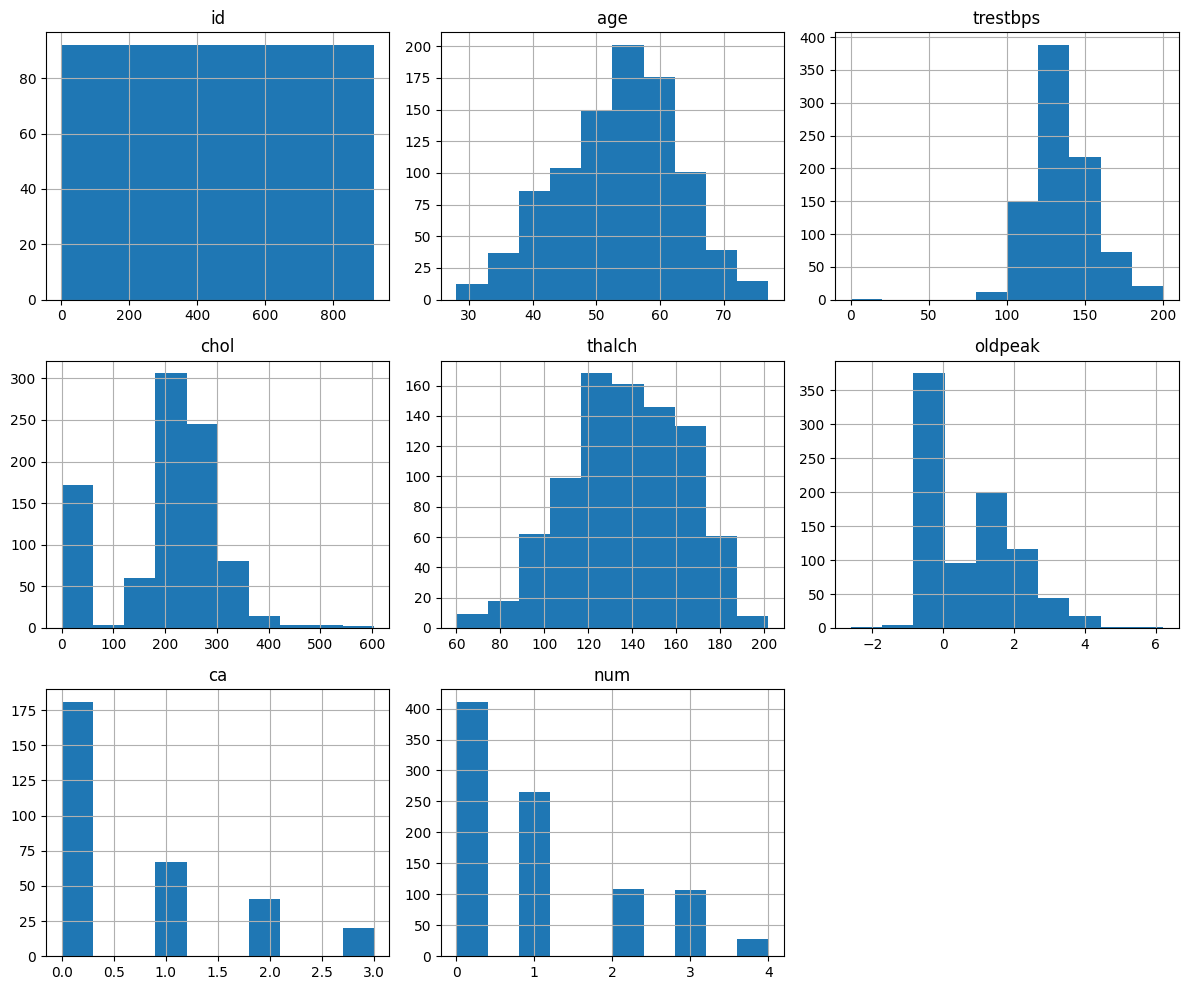

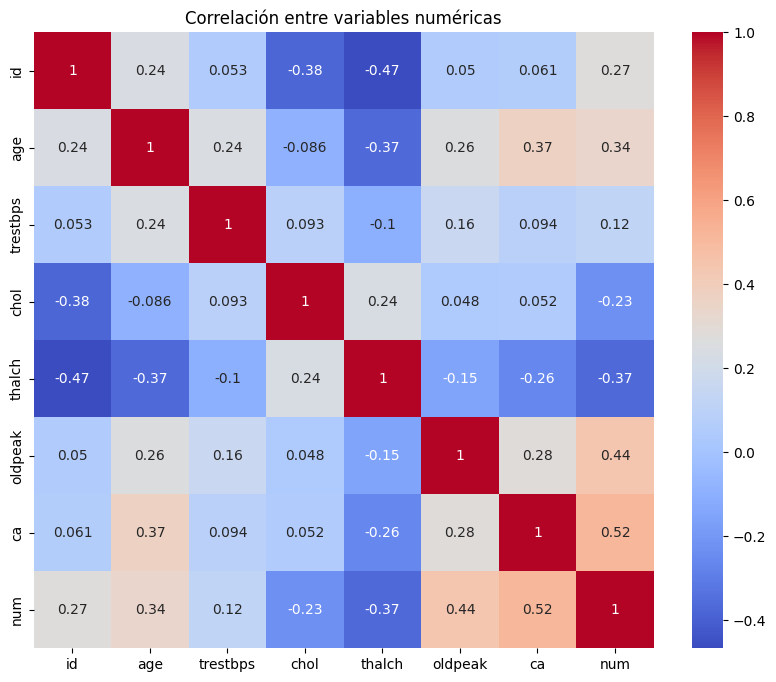

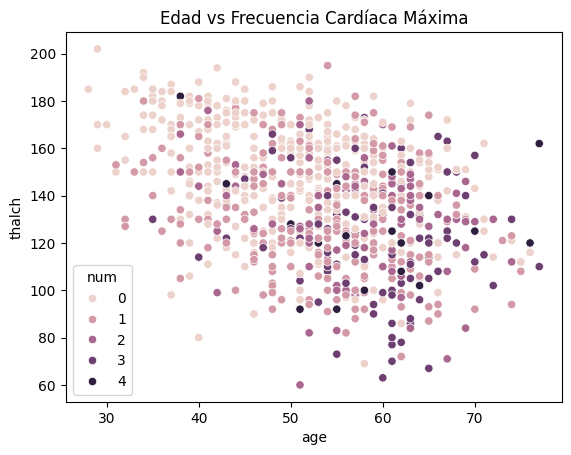

Reporte clasificación:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82        75
           1       0.89      0.86      0.87       109

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

ROC-AUC: 0.8511926605504587


/tmp/ipython-input-2-3189742156.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['trestbps'].fillna(df['trestbps'].median(), inplace=True)
/tmp/ipython-input-2-3189742156.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Mejores parámetros: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
ROC-AUC óptimo: 0.8195107033639144
Reporte optimizado:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79        75
           1       0.87      0.83      0.85       109

    accuracy                           0.82       184
   macro avg       0.81      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:04:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [2]:
# Carga y Librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Cargar dataset
path = "/content/drive/MyDrive/0002 Python - Data Science/Datasets/heart_disease_uci.csv"
df = pd.read_csv(path)

# Exploración Inicial
print(df.head())
print(df.info())
print(df.describe(include='all'))
print("Valores nulos:\n", df.isnull().sum())

# Análisis Estadístico
for col in df.select_dtypes(include='object').columns:
    print(f"{col}:\n", df[col].value_counts(), "\n")

# Visualizaciones
df.select_dtypes(include=['float64', 'int64']).hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()

sns.scatterplot(data=df, x='age', y='thalch', hue='num')
plt.title('Edad vs Frecuencia Cardíaca Máxima')
plt.show()

# Tratamiento de Nulos
df['trestbps'].fillna(df['trestbps'].median(), inplace=True)
df['chol'].fillna(df['chol'].median(), inplace=True)
df['thalch'].fillna(df['thalch'].median(), inplace=True)
df['oldpeak'].fillna(df['oldpeak'].median(), inplace=True)

# Eliminar columnas con demasiados nulos
df.drop(columns=['ca', 'thal'], inplace=True)

# Preprocesamiento
X = df.drop(columns=['id', 'num'])
y = (df['num'] > 0).astype(int)

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento con XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
pipeline.fit(X_train, y_train)

# Evaluación Inicial
y_pred = pipeline.predict(X_test)
print("Reporte clasificación:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

# Optimización de Hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

# Resultados finales
print("Mejores parámetros:", grid.best_params_)
print("ROC-AUC óptimo:", roc_auc_score(y_test, grid.predict(X_test)))
print("Reporte optimizado:\n", classification_report(y_test, grid.predict(X_test)))


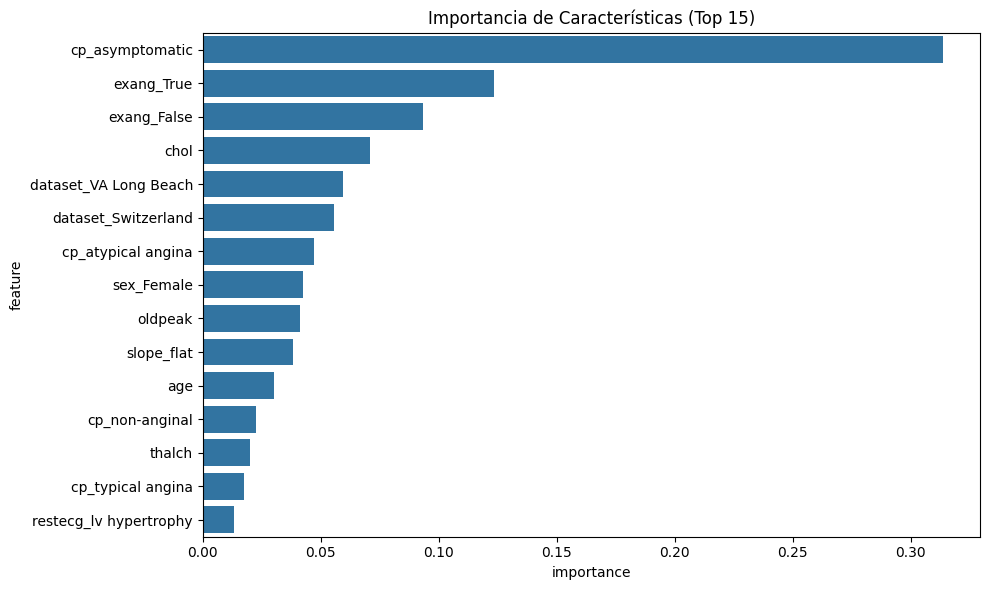

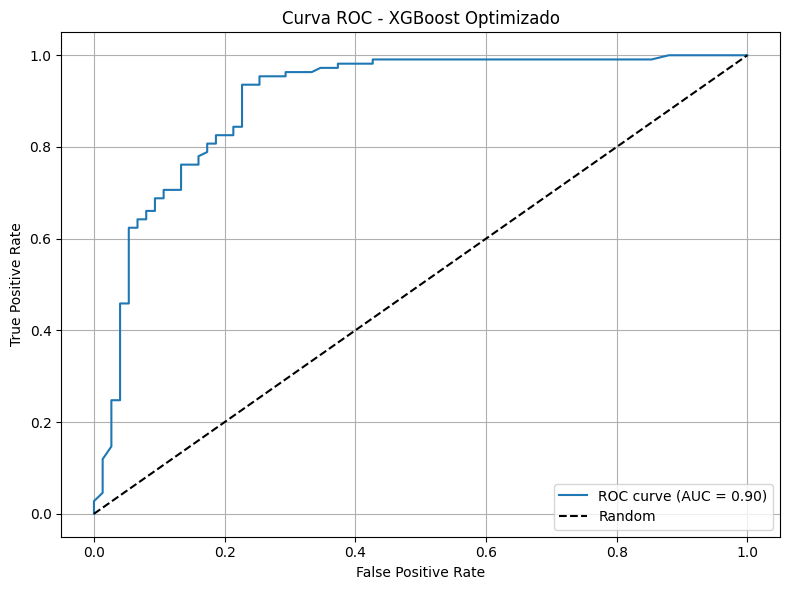

In [3]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Importancia de características (después del GridSearch)
best_model = grid.best_estimator_.named_steps['classifier']
ohe_feature_names = grid.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_feature_names)
importances = best_model.feature_importances_

# Gráfico de importancia
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title("Importancia de Características (Top 15)")
plt.tight_layout()
plt.show()

# Curva ROC
y_probs = grid.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost Optimizado')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()
